# Make classification data and get it ready

In [ ]:
import torch
from sklearn.datasets import make_circles

# Make 1000 circle samples
n_samples = 1000
X, y = make_circles(n_samples=n_samples, noise=0.03, random_state=42)

len(X), len(y)

(1000, 1000)

In [ ]:
print("First 5 rows of X:")
print(X[:5])

print("\nFirst 5 rows of y:")
print(y[:5])
# print(torch.tensor(y[:5]).unsqueeze(dim=1).numpy())

First 5 rows of X:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 rows of y:
[1 1 1 1 0]


In [ ]:
import pandas as pd

circles = pd.DataFrame({ "X1": X[:, 0],
                         "X2": X[:, 1],
                         "label": y})

circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [ ]:
# Check different labels
circles.label.value_counts()

,count
label,
1,500
0,500


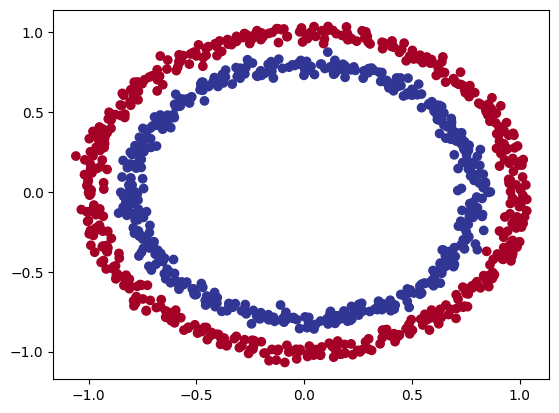

In [ ]:
# Visualize the data with a plot
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [ ]:
type(X), X.shape, type(y), y.shape

(numpy.ndarray, (1000, 2), numpy.ndarray, (1000,))

In [ ]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [ ]:
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
import torch
from torch import nn
from sklearn import datasets

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

In [ ]:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
next(model_0.parameters()).device

device(type='cpu')

In [ ]:
# More simple syntax with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
)

# Move into GPU
model_0.to(device)

# Check the current used device
next(model_0.parameters()).device

device(type='cpu')

In [ ]:
# Show the model weights
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0801,  0.4801],
                      [-0.3885,  0.6759],
                      [ 0.3043, -0.6661],
                      [ 0.1508, -0.0643],
                      [ 0.4074,  0.6520]])),
             ('0.bias', tensor([ 0.6693, -0.4657,  0.5286, -0.1265, -0.5379])),
             ('1.weight',
              tensor([[ 0.0722,  0.1624, -0.0995, -0.1669, -0.1991]])),
             ('1.bias', tensor([0.0465]))])

In [ ]:
# Move training and testing data to the right 'device'
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

X_train.device, y_train.device, X_test.device, y_test.device

(device(type='cpu'),
 device(type='cpu'),
 device(type='cpu'),
 device(type='cpu'))

In [ ]:
# Do some predictions using the raw untrained model (called logits)
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds[:10], y_preds.shape, y_test[:10], y_test.shape

(tensor([[ 0.2345],
         [ 0.1797],
         [ 0.2104],
         [ 0.2420],
         [-0.0560],
         [-0.0874],
         [-0.0306],
         [-0.0938],
         [ 0.2217],
         [ 0.1730]]),
 torch.Size([200, 1]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 torch.Size([200]))

In [ ]:
# Setup a loss function and an optimizer
loss_fn = nn.BCEWithLogitsLoss()  # includes BCELoss + Sigmoid
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [ ]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

The raw outputs (unmodified) of the equation ($ \mathbf{y} = x \cdot \mathbf{Weights}^T + \mathbf{bias} $) and in turn, the raw outputs of our model are often referred to as **logits**.

In [ ]:
# Use sigmoid on model logits
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test)

# View the frist 5 outputs of the forward pass on the test data
y_logits[:5]

tensor([[ 0.2345],
        [ 0.1797],
        [ 0.2104],
        [ 0.2420],
        [-0.0560]])

Going from raw model outputs (i.e., **Logits**) to predicted labels:

* Logits  -->  Prediction Probabilities  -->
 Prediction Labels

In [ ]:
# Use sigmoid on model logits to get *Prediction Probabilities*
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs[:5]

tensor([[0.5584],
        [0.5448],
        [0.5524],
        [0.5602],
        [0.4860]])

In [ ]:
# Find the predicted labels (round the probabilities)
y_pred_labels = torch.round(y_pred_probs)
y_pred_labels[:5], y_pred_labels.shape

(tensor([[1.],
         [1.],
         [1.],
         [1.],
         [0.]]),
 torch.Size([200, 1]))

In [ ]:
# Or an equivalent simple syntax in one line
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test)))

### Now let's train our model

In [ ]:
X_train.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]), torch.Size([800]), torch.Size([200]))

In [ ]:
epochs = 100

for epoch in range(epochs):
  # Set the model in training mode
  model_0.train()

  # Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate the loss using BCEWithLogits function
  loss = loss_fn(y_logits, y_train)

  # Measure the accuracy
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss backward (backpropagation)
  loss.backward()

  # Optimizer step (Gradient Descent)
  optimizer.step()


  # Set the model in testing mode
  model_0.eval()

  with torch.inference_mode():
    # Forward pass
    y_test_logits = model_0(X_test).squeeze()
    y_test_preds = torch.round(torch.sigmoid(y_test_logits))

    # Calculate the loss
    loss_test = loss_fn(y_test_logits, y_test)

    # Measure the accuracy
    test_acc = accuracy_fn(y_true=y_test, y_pred=y_test_preds)


  # Print out what's happenin'
  if epoch % 10 == 0:
    print(f"Epoch: {epoch:02} | Train Loss: {loss:.5f} | Train Acc.: {acc:.2f} | Test Loss: {loss_test:.5f} | Test Acc.: {test_acc:.2f}")

Epoch: 00 | Train Loss: 0.69686 | Train Acc.: 51.12 | Test Loss: 0.69643 | Test Acc.: 55.50
Epoch: 10 | Train Loss: 0.69585 | Train Acc.: 49.88 | Test Loss: 0.69561 | Test Acc.: 54.50
Epoch: 20 | Train Loss: 0.69535 | Train Acc.: 49.88 | Test Loss: 0.69514 | Test Acc.: 54.50
Epoch: 30 | Train Loss: 0.69502 | Train Acc.: 49.50 | Test Loss: 0.69481 | Test Acc.: 54.50
Epoch: 40 | Train Loss: 0.69478 | Train Acc.: 49.62 | Test Loss: 0.69454 | Test Acc.: 52.50
Epoch: 50 | Train Loss: 0.69458 | Train Acc.: 49.88 | Test Loss: 0.69432 | Test Acc.: 52.00
Epoch: 60 | Train Loss: 0.69442 | Train Acc.: 49.75 | Test Loss: 0.69414 | Test Acc.: 52.00
Epoch: 70 | Train Loss: 0.69428 | Train Acc.: 49.75 | Test Loss: 0.69399 | Test Acc.: 51.50
Epoch: 80 | Train Loss: 0.69416 | Train Acc.: 49.75 | Test Loss: 0.69387 | Test Acc.: 51.00
Epoch: 90 | Train Loss: 0.69406 | Train Acc.: 49.75 | Test Loss: 0.69377 | Test Acc.: 51.00


## Plot decision boundaries for training and test sets

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download...")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

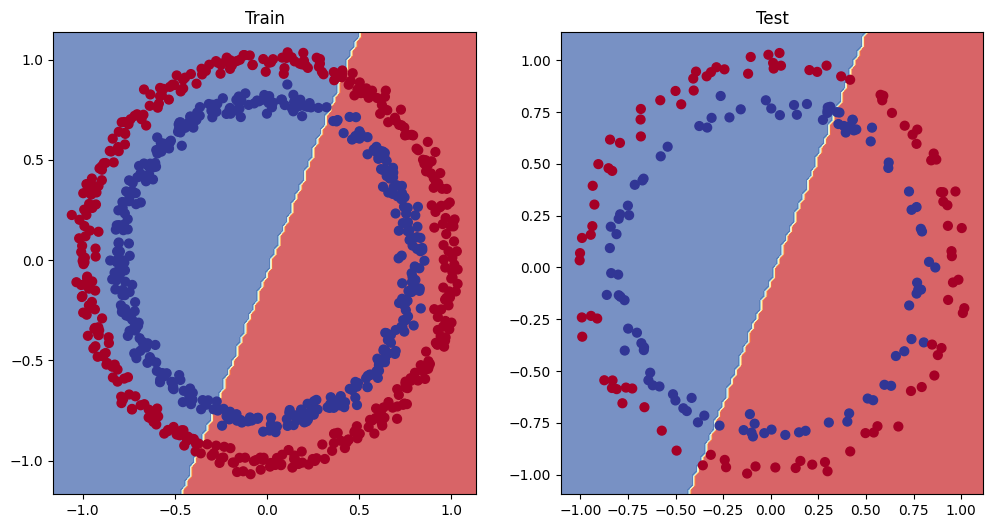

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## Build another version of the model to try to improve it

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1()
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.3133,  0.2544],
                      [-0.5059,  0.2714],
                      [-0.6005, -0.5319],
                      [ 0.5031,  0.3591],
                      [ 0.0234,  0.5860],
                      [-0.1159,  0.0845],
                      [ 0.7018,  0.6800],
                      [-0.0162, -0.2831],
                      [ 0.3334, -0.4813],
                      [ 0.5234,  0.3840]])),
             ('layer_1.bias',
              tensor([ 0.1419,  0.4352, -0.2732,  0.1110, -0.4665, -0.1527,  0.0253,  0.0452,
                       0.2087,  0.5967])),
             ('layer_2.weight',
              tensor([[ 0.0348,  0.1529,  0.1134, -0.1113,  0.0268,  0.2167, -0.0394,  0.2703,
                       -0.0906, -0.1086],
                      [-0.1711,  0.0826, -0.1460, -0.1199,  0.1063,  0.0901,  0.1367,  0.2327,
                       -0.0444, -0.0304],
                      [-0.1028, -0.2014, -0.0483,  0.0751,  0.1432,  0.1

In [ ]:
# Setup a loss function and an optimizer
loss_fn = nn.BCEWithLogitsLoss()  # includes BCELoss + Sigmoid
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.1)

In [ ]:
# Write a training and evaluation loops for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Move data to the current used target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
model_1 = model_1.to(device)

Using device: cpu


In [ ]:
X_train.device, y_train.device, X_test.device, y_test.device

(device(type='cpu'),
 device(type='cpu'),
 device(type='cpu'),
 device(type='cpu'))

In [ ]:
epochs = 1000

for epoch in range(epochs):
  #--- Training
  # Set model in the training mode
  model_1.train()

  # Forward Pass
  y_logits = model_1(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))  # Logits --> Prediction Probabilities --> Prediction Labels

  # Calculate the loss
  train_loss = loss_fn(y_logits, y_train)

  # Calculate the accuracy
  train_acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

  # Zero gradients for avoiding accumlating in each epoch
  optimizer.zero_grad()

  # Loss backward (Backpropagation)
  train_loss.backward()

  # Optimizer step (Gradient Descent)
  optimizer.step()


  #--- Testing
  model_1.eval()

  with torch.inference_mode():
    # Forward Pass
    y_test_logits = model_1(X_test).squeeze()
    y_test_preds = torch.round(torch.sigmoid(y_test_logits))  # Logits --> Prediction Probabilities --> Prediction Labels  (Binary Classification → Sigmoid)

    # Calculate the loss
    test_loss = loss_fn(y_test_logits, y_test)

    # Calculate the accuracy
    test_acc = accuracy_fn(y_true=y_test, y_pred=y_test_preds)


  # Print out what's happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch:03} | Train Loss: {train_loss:.5f} | Train Acc.: {train_acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc.: {test_acc:.2f}%")

Epoch: 000 | Train Loss: 0.69824 | Train Acc.: 50.00% | Test Loss: 0.76013 | Test Acc.: 50.00%
Epoch: 100 | Train Loss: 0.69298 | Train Acc.: 51.50% | Test Loss: 0.69470 | Test Acc.: 45.50%
Epoch: 200 | Train Loss: 0.69298 | Train Acc.: 51.00% | Test Loss: 0.69468 | Test Acc.: 46.00%
Epoch: 300 | Train Loss: 0.69298 | Train Acc.: 51.00% | Test Loss: 0.69468 | Test Acc.: 46.00%
Epoch: 400 | Train Loss: 0.69298 | Train Acc.: 51.00% | Test Loss: 0.69468 | Test Acc.: 46.00%
Epoch: 500 | Train Loss: 0.69298 | Train Acc.: 51.00% | Test Loss: 0.69468 | Test Acc.: 46.00%
Epoch: 600 | Train Loss: 0.69298 | Train Acc.: 51.00% | Test Loss: 0.69468 | Test Acc.: 46.00%
Epoch: 700 | Train Loss: 0.69298 | Train Acc.: 51.00% | Test Loss: 0.69468 | Test Acc.: 46.00%
Epoch: 800 | Train Loss: 0.69298 | Train Acc.: 51.00% | Test Loss: 0.69468 | Test Acc.: 46.00%
Epoch: 900 | Train Loss: 0.69298 | Train Acc.: 51.00% | Test Loss: 0.69468 | Test Acc.: 46.00%


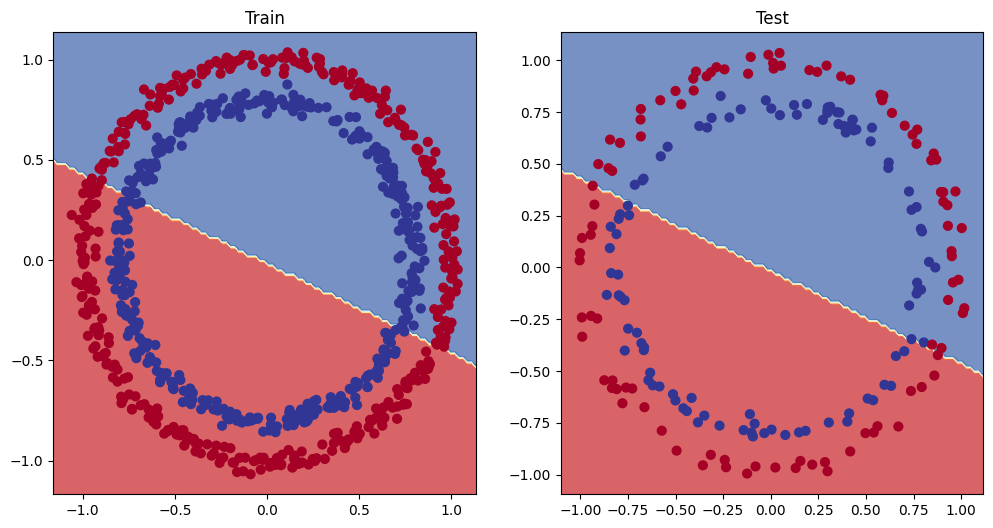

In [ ]:
# Plot the decision boundary
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model=model_1, X=X_train, y=y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model=model_1, X=X_test, y=y_test)

# Preparing data to see if our model can fit a straight line.

- One way to troubleshoot to a larger problem is to test out a smaller problem.

In [ ]:
weight = 0.7
bias = 0.3

X_regression = torch.arange(0, 1, 0.01).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

X_regression[:5], X_regression.shape, y_regression[:5], y_regression.shape

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 torch.Size([100, 1]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]),
 torch.Size([100, 1]))

In [ ]:
len(X_regression), len(y_regression)

(100, 100)

In [ ]:
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

In [ ]:
def plot_predictions(train_data, train_labels, test_data, test_labels, predictions=None):
  plt.figure(figsize=(12,6))

  plt.scatter(train_data, train_labels, s=4, label="Training data")
  plt.scatter(test_data, test_labels, s=4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, s=4, label="Predictions")

  plt.legend()

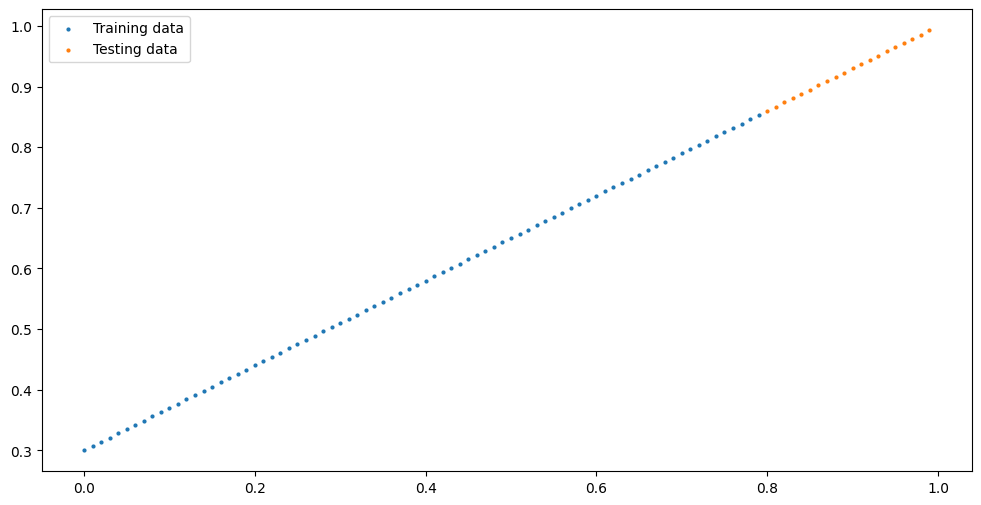

In [ ]:
plot_predictions(X_train_regression, y_train_regression, X_test_regression, y_test_regression)

In [ ]:
# We need to adjust mode_1 to fit the regression straight line
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
X_train_regression[:5], y_train_regression[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Split the data into train and test sets
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

Using device: cpu


In [ ]:
# Build the model
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
)

model_2 = model_2.to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Setup a loss function and an optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

In [ ]:
# Training and testing our model
epochs = 1000

for epoch in range(epochs):
  #--- Training
  # Set the model in training mode
  model_2.train()

  # Forward Pass
  y_preds = model_2(X_train_regression)

  # Calculate the loss
  train_loss = loss_fn(y_preds, y_train_regression)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss Backward (Backpropagation)
  train_loss.backward()

  # Optimizer step (Gradient Descent)
  optimizer.step()


  #--- Testing
  # Set the model in testing mode
  model_2.eval()

  with torch.inference_mode():
    # Forward Pass
    y_test_preds = model_2(X_test_regression)

    # Calculate the loss
    test_loss = loss_fn(y_test_preds, y_test_regression)


  # Print out what's happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch:02} | Train Loss: {train_loss:0.5f} | Test Loss: {test_loss:0.5f}")

Epoch: 00 | Train Loss: 0.75986 | Test Loss: 0.91103
Epoch: 100 | Train Loss: 0.02858 | Test Loss: 0.00081
Epoch: 200 | Train Loss: 0.02533 | Test Loss: 0.00209
Epoch: 300 | Train Loss: 0.02137 | Test Loss: 0.00305
Epoch: 400 | Train Loss: 0.01964 | Test Loss: 0.00341
Epoch: 500 | Train Loss: 0.01940 | Test Loss: 0.00387
Epoch: 600 | Train Loss: 0.01903 | Test Loss: 0.00379
Epoch: 700 | Train Loss: 0.01878 | Test Loss: 0.00381
Epoch: 800 | Train Loss: 0.01840 | Test Loss: 0.00329
Epoch: 900 | Train Loss: 0.01798 | Test Loss: 0.00360


In [ ]:
# Make some predictions (inference) to test our model
model_2.eval()

with torch.inference_mode():
  y_preds = model_2(y_test_regression)

y_preds[:5], y_preds.shape

(tensor([[0.8640],
         [0.8686],
         [0.8732],
         [0.8778],
         [0.8824]]),
 torch.Size([20, 1]))

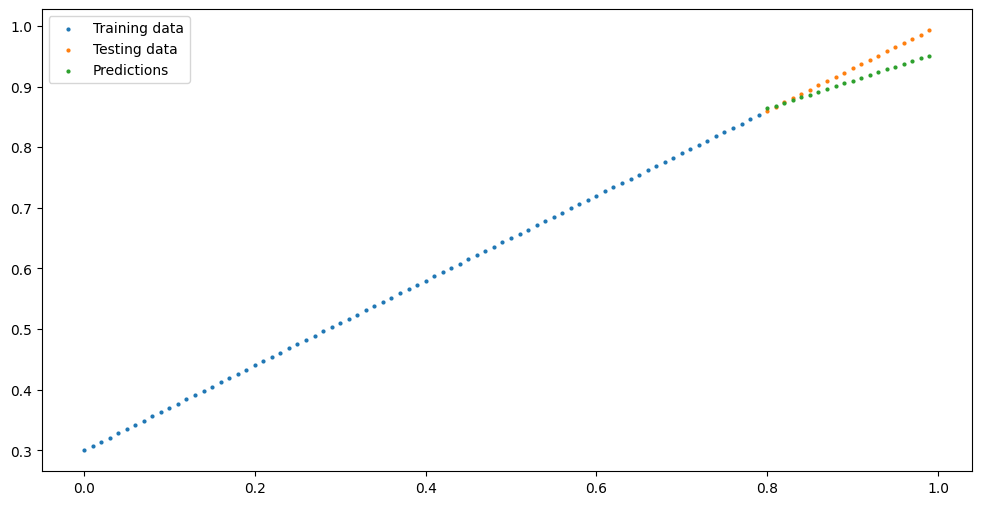

In [ ]:
plot_predictions(
    train_data=X_train_regression.cpu(),
    train_labels=y_train_regression.cpu(),
    test_data=X_test_regression.cpu(),
    test_labels=y_test_regression.cpu(),
    predictions=y_preds.cpu()
)

## Build the new non-linear version of the model

In [ ]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import pandas as pd

X, y = make_circles(n_samples=1000, noise=0.03, random_state=42)
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
circles = pd.DataFrame({"X1": X[:,0], "X2": X[:,1], "label": y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [ ]:
circles.label.value_counts()

,count
label,
1,500
0,500


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.from_numpy(X_train).type(torch.float).to(device)
X_test = torch.from_numpy(X_test).type(torch.float).to(device)

y_train = torch.from_numpy(y_train).type(torch.float).to(device)
y_test = torch.from_numpy(y_test).type(torch.float).to(device)

type(X_train), X_train.device

(torch.Tensor, device(type='cpu'))

In [ ]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=1000)
    self.layer_2 = nn.Linear(in_features=1000, out_features=1000)
    self.layer_3 = nn.Linear(in_features=1000, out_features=1)
    self.relu = nn.ReLU()  # for non-linearity

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=1000, bias=True)
  (layer_2): Linear(in_features=1000, out_features=1000, bias=True)
  (layer_3): Linear(in_features=1000, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# Setup a loss function and an optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

In [ ]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Hyperparameters
epochs = 500
epochs_values = []
train_loss_values = []
test_loss_values = []

for epoch in range(epochs):
  ###--- Training
  # Set model in training mode
  model_3.train()

  # Forward Pass
  y_logits = model_3(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))  # Logits --> Probability Predictions --> Labels (Binary Classification)

  # Calculate the loss and accuracy
  train_loss = loss_fn(y_logits, y_train)  # BCEWithLogitsLoss
  train_acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

  optimizer.zero_grad()

  # Loss Backward (Backpropagation)
  train_loss.backward()

  # Step the optimizer (Gradient Descent)
  optimizer.step()

  ###--- Testing
  # Set model in testing mode
  model_3.eval()

  with torch.inference_mode():
    # Forward Pass
    y_test_logits = model_3(X_test).squeeze()
    y_test_preds = torch.round(torch.sigmoid(y_test_logits))

    # Calculate the loss and accuracy
    test_loss = loss_fn(y_test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=y_test_preds)


  # Print out what's happening
  if epoch % 100 == 0:
    epochs_values.append(epoch)
    train_loss_values.append(train_loss.detach().cpu().numpy())
    test_loss_values.append(test_loss.detach().cpu().numpy())

    print(f"Epoch: {epoch:03} | Train Loss: {train_loss:.5f} | Train Acc.: {train_acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc.: {test_acc:.2f}%")

Epoch: 000 | Train Loss: 0.69637 | Train Acc.: 47.62% | Test Loss: 0.69137 | Test Acc.: 53.50%
Epoch: 100 | Train Loss: 0.55420 | Train Acc.: 50.88% | Test Loss: 0.56024 | Test Acc.: 50.50%
Epoch: 200 | Train Loss: 0.43321 | Train Acc.: 64.50% | Test Loss: 0.46353 | Test Acc.: 67.00%
Epoch: 300 | Train Loss: 0.21437 | Train Acc.: 95.25% | Test Loss: 0.25643 | Test Acc.: 90.50%
Epoch: 400 | Train Loss: 0.04155 | Train Acc.: 100.00% | Test Loss: 0.06536 | Test Acc.: 100.00%
Epoch: 500 | Train Loss: 0.02490 | Train Acc.: 100.00% | Test Loss: 0.04371 | Test Acc.: 100.00%
Epoch: 600 | Train Loss: 0.01772 | Train Acc.: 100.00% | Test Loss: 0.03375 | Test Acc.: 100.00%
Epoch: 700 | Train Loss: 0.01373 | Train Acc.: 100.00% | Test Loss: 0.02794 | Test Acc.: 100.00%
Epoch: 800 | Train Loss: 0.01121 | Train Acc.: 100.00% | Test Loss: 0.02411 | Test Acc.: 100.00%
Epoch: 900 | Train Loss: 0.00947 | Train Acc.: 100.00% | Test Loss: 0.02137 | Test Acc.: 100.00%


In [ ]:
model_3.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.6103,  0.5622],
                      [-0.4802, -0.1153],
                      [ 0.1439,  0.3683],
                      ...,
                      [ 0.1880,  0.4079],
                      [-0.6845,  0.0518],
                      [-0.2733,  0.5472]])),
             ('layer_1.bias',
              tensor([-0.4239,  0.4598,  0.4339,  0.3431,  0.6697,  0.0919, -0.5956,  0.5593,
                       0.0509, -0.0093, -0.6736, -0.1685, -0.3457,  0.6843,  0.5185,  0.5183,
                       0.4756, -0.4178, -0.2803, -0.2654, -0.2699,  0.5436,  0.2035,  0.5617,
                      -0.0344, -0.6303, -0.1998,  0.4936,  0.4316,  0.1835, -0.2044, -0.6600,
                      -0.3618,  0.3436, -0.2604,  0.2967,  0.1792, -0.2656,  0.4241, -0.2207,
                      -0.0365, -0.2585, -0.6688,  0.0852,  0.1557, -0.3395,  0.3895, -0.6343,
                      -0.6346, -0.4084, -0.2368, -0.0904, -0.1439,  0.3171, -0.6206,  0.0756

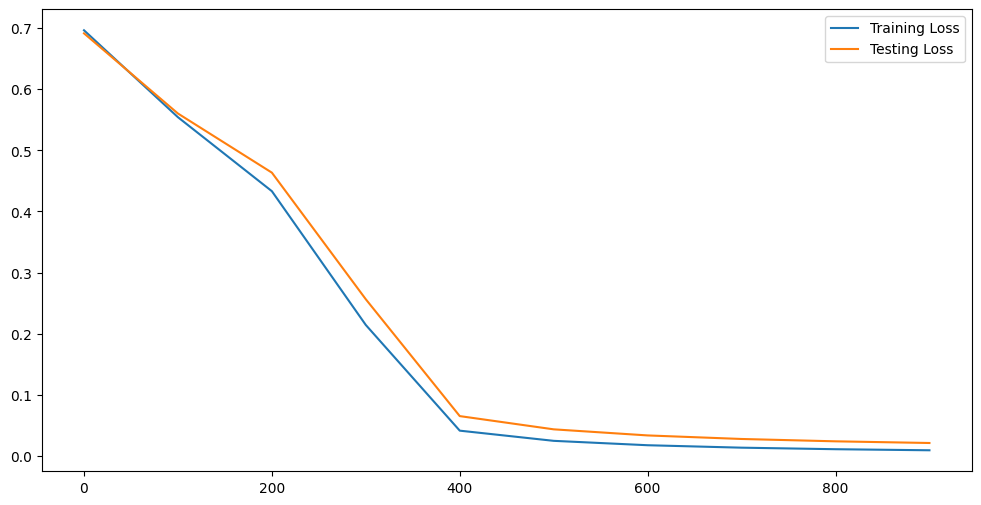

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(epochs_values, train_loss_values, label="Training Loss")
plt.plot(epochs_values, test_loss_values, label="Testing Loss")
plt.legend()

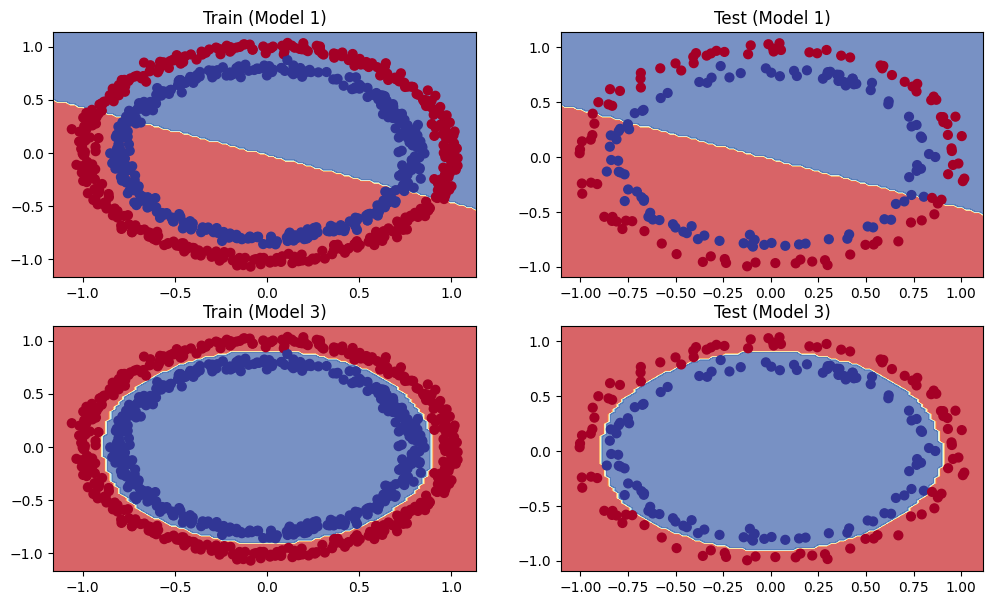

In [ ]:
plt.figure(figsize=(12,7))

###--- Model 1
plt.subplot(2,2,1)
plt.title("Train (Model 1)")
plot_decision_boundary(model=model_1, X=X_train, y=y_train)

plt.subplot(2,2,2)
plt.title("Test (Model 1)")
plot_decision_boundary(model=model_1, X=X_test, y=y_test)


###--- Model 3
plt.subplot(2,2,3)
plt.title("Train (Model 3)")
plot_decision_boundary(model=model_3, X=X_train, y=y_train)

plt.subplot(2,2,4)
plt.title("Test (Model 3)")
plot_decision_boundary(model=model_3, X=X_test, y=y_test)

---------------------
# Replicating some of the most commonly used non-linear activation functions for practice!

In [ ]:
A = torch.arange(-10, 10, 1, dtype=torch.float)

(tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
           2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
         8., 9.]))

## 1) Replicating `ReLU (Rectified Linear Unit)` non-linear activation function.

In [ ]:
def ReLU(x: torch.Tensor) -> torch.Tensor:
  return torch.max(torch.tensor(0), x)

In [ ]:
A, ReLU(A)

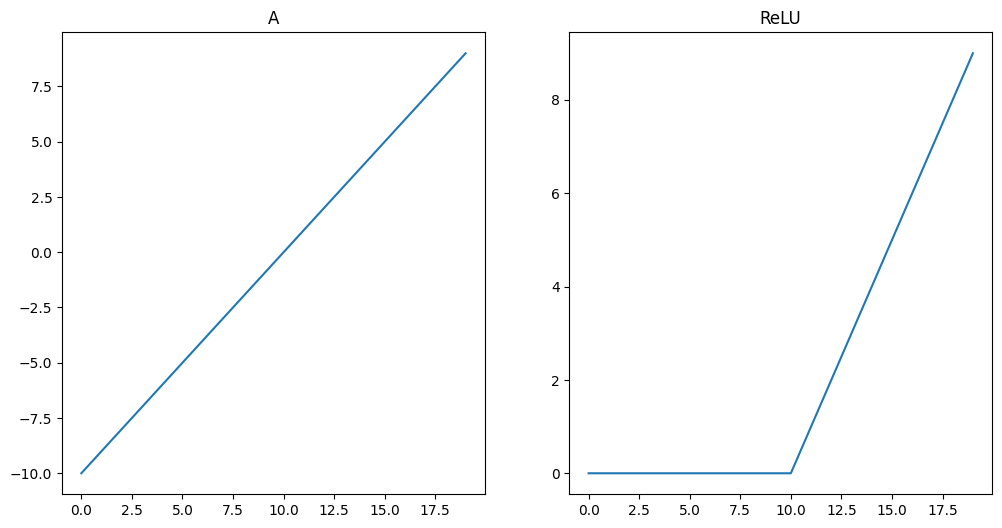

In [ ]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("A")
plt.plot(A)

plt.subplot(1,2,2)
plt.title("ReLU")
plt.plot(ReLU(A))

## 2) Replicating `LeakyReLU (Leaky Rectified Linear Unit)` non-linear activation function.

In [ ]:
def LeakyReLU(x: torch.Tensor, alpha=0.1) -> torch.Tensor:
  return torch.maximum(alpha * x, x)

In [ ]:
A, LeakyReLU(A)

(tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
           2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.]),
 tensor([-1.0000, -0.9000, -0.8000, -0.7000, -0.6000, -0.5000, -0.4000, -0.3000,
         -0.2000, -0.1000,  0.0000,  1.0000,  2.0000,  3.0000,  4.0000,  5.0000,
          6.0000,  7.0000,  8.0000,  9.0000]))

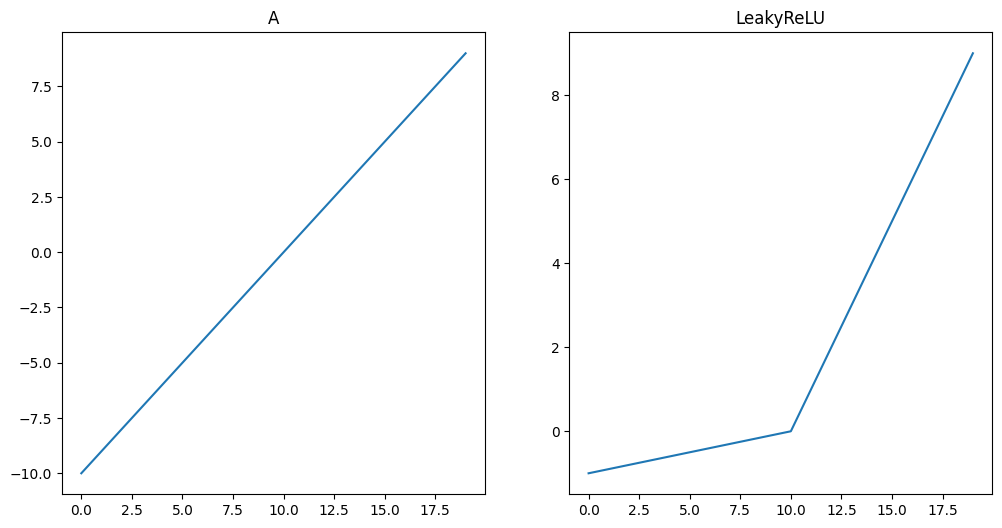

In [ ]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("A")
plt.plot(A)

plt.subplot(1,2,2)
plt.title("LeakyReLU")
plt.plot(LeakyReLU(A))

## 3) Replicating `Sigmoid` non-linear activation function.

In [ ]:
def Sigmoid(x: torch.Tensor) -> torch.Tensor:
  return 1 / (1 + torch.exp(-x))

In [ ]:
A, Sigmoid(A)

(tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
           2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.]),
 tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
         1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
         8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
         9.9966e-01, 9.9988e-01]))

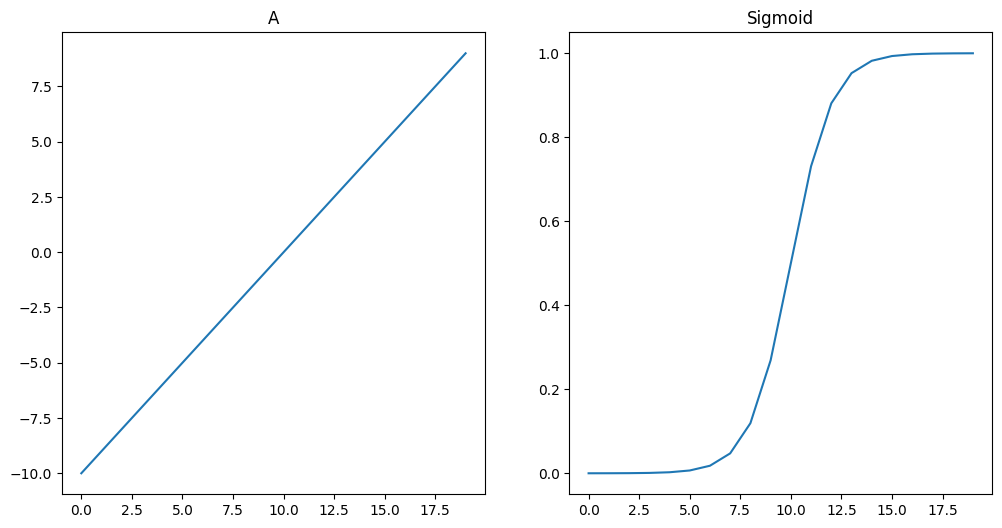

In [ ]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("A")
plt.plot(A)

plt.subplot(1,2,2)
plt.title("Sigmoid")
plt.plot(Sigmoid(A))

## 4) Replicating `Tanh` non-linear activation function.

In [ ]:
def Tanh(x: torch.Tensor) -> torch.Tensor:
  return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

In [ ]:
A, Tanh(A)

(tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
           2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.]),
 tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -0.9993, -0.9951,
         -0.9640, -0.7616,  0.0000,  0.7616,  0.9640,  0.9951,  0.9993,  0.9999,
          1.0000,  1.0000,  1.0000,  1.0000]))

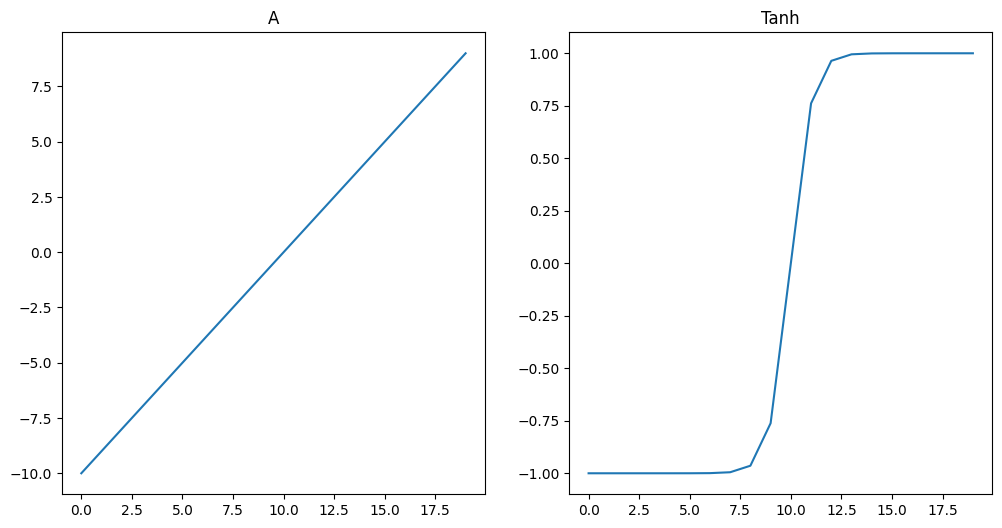

In [ ]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("A")
plt.plot(A)

plt.subplot(1,2,2)
plt.title("Tanh")
plt.plot(Tanh(A))

## 5) Replicating `Softplus` non-linear activation function.

In [ ]:
def Softplus(x: torch.Tensor, beta: float = 1.0) -> torch.Tensor:
  return (1/beta) * torch.log(1 + torch.exp(beta * x))

In [ ]:
A, Softplus(A)

(tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
           2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.]),
 tensor([4.5418e-05, 1.2337e-04, 3.3540e-04, 9.1142e-04, 2.4757e-03, 6.7153e-03,
         1.8150e-02, 4.8587e-02, 1.2693e-01, 3.1326e-01, 6.9315e-01, 1.3133e+00,
         2.1269e+00, 3.0486e+00, 4.0181e+00, 5.0067e+00, 6.0025e+00, 7.0009e+00,
         8.0003e+00, 9.0001e+00]))

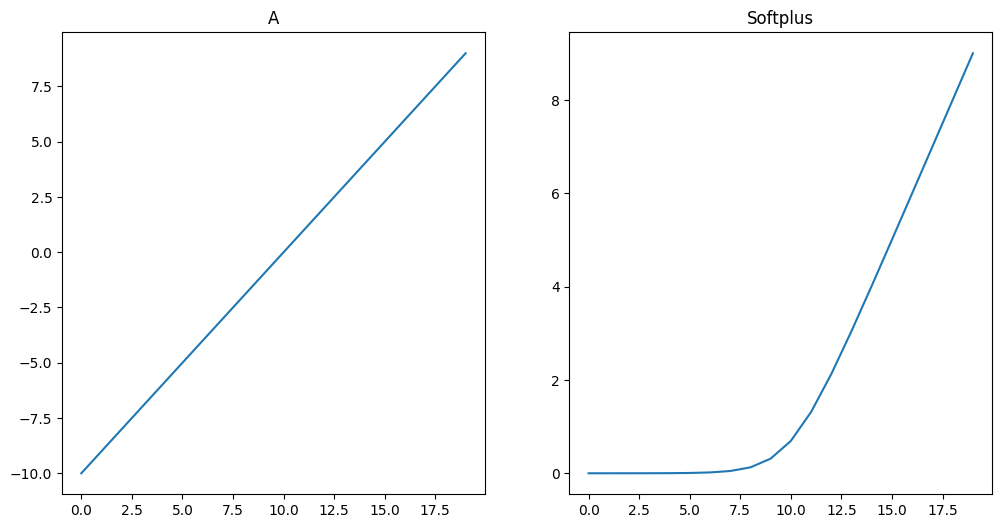

In [ ]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("A")
plt.plot(A)

plt.subplot(1,2,2)
plt.title("Softplus")
plt.plot(Softplus(A))

## 6) Replicating `Softmax` non-linear activation function.

In [ ]:
def Softmax(x: torch.Tensor) -> torch.Tensor:
  return torch.exp(x) / torch.sum(torch.exp(x), dim=0)

In [ ]:
A, Softmax(A)

(tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
           2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.]),
 tensor([3.5416e-09, 9.6272e-09, 2.6169e-08, 7.1136e-08, 1.9337e-07, 5.2563e-07,
         1.4288e-06, 3.8839e-06, 1.0557e-05, 2.8698e-05, 7.8010e-05, 2.1205e-04,
         5.7642e-04, 1.5669e-03, 4.2592e-03, 1.1578e-02, 3.1471e-02, 8.5548e-02,
         2.3254e-01, 6.3212e-01]))

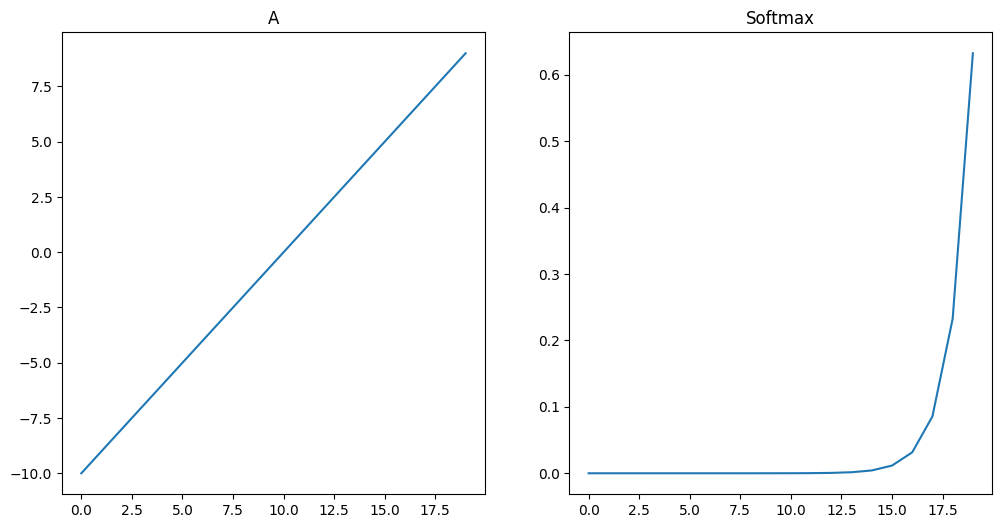

In [ ]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("A")
plt.plot(A)

plt.subplot(1,2,2)
plt.title("Softmax")
plt.plot(Softmax(A))

----------------------
# Going beyond **Binary Classification** Problems  -->  **Multi-Class Classification** Problems

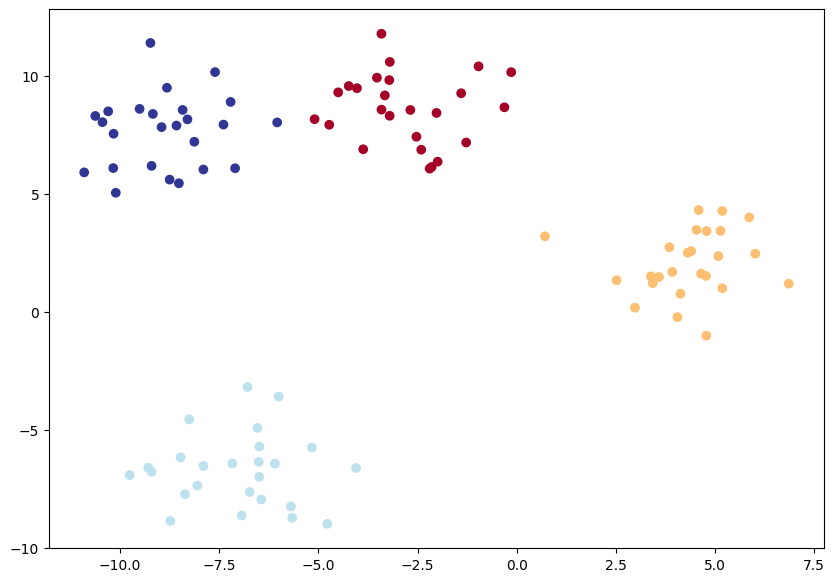

In [ ]:
from sklearn.datasets import make_blobs


# Hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42


# Create multi-class data
X_blob, y_blob = make_blobs(n_samples=100,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)


# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)


# Split the data into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)


# Plot the data (visualize, visualize, visualize)
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Move the data to the current used device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

X_blob_train[:5], y_blob_train[:5]

(tensor([[-9.1735,  8.3945],
         [-4.7270,  7.9345],
         [ 2.5168,  1.3422],
         [-6.9317, -8.6331],
         [-6.4933, -6.9918]]),
 tensor([3, 0, 1, 2, 2]))

In [ ]:
blobs = pd.DataFrame({ "X1": X_blob[:,0], "X2": X_blob[:,1], "label": y_blob })
blobs.head()

,X1,X2,label
0,-10.108519,5.051252,3
1,-5.659351,-8.726406,2
2,-3.213409,9.828126,0
3,-4.775436,-8.982886,2
4,-8.301647,8.164700,3


In [ ]:
blobs.label.value_counts()

,count
label,
3,25
2,25
0,25
1,25


In [ ]:
class BlobModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=8)
    self.layer_2 = nn.Linear(in_features=8, out_features=8)
    self.layer_3 = nn.Linear(in_features=8, out_features=4)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_0 = BlobModelV0().to(device)
model_0

BlobModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=8, bias=True)
  (layer_3): Linear(in_features=8, out_features=4, bias=True)
  (relu): ReLU()
)

In [ ]:
X_blob_train.shape, torch.unique(y_blob_train)

(torch.Size([80, 2]), tensor([0, 1, 2, 3]))

In [ ]:
class BlobModelV1(nn.Module):
  def __init__(self, in_features, out_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=out_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)


model_0 = BlobModelV1(
    in_features=2,
    out_features=4,
    hidden_units=8
).to(device)

model_0

BlobModelV1(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
model_0.state_dict()

OrderedDict([('linear_layer_stack.0.weight',
              tensor([[-0.5988,  0.4893],
                      [-0.1946, -0.2711],
                      [-0.5869, -0.7030],
                      [ 0.2023, -0.1545],
                      [ 0.2753, -0.5803],
                      [ 0.5250, -0.5191],
                      [-0.1221,  0.1477],
                      [ 0.3650,  0.5709]])),
             ('linear_layer_stack.0.bias',
              tensor([ 0.6441, -0.5607,  0.1780, -0.3041, -0.0775, -0.5293,  0.6441, -0.5190])),
             ('linear_layer_stack.2.weight',
              tensor([[ 0.1890,  0.1243,  0.1149, -0.1911,  0.3214,  0.0777,  0.0455, -0.3116],
                      [ 0.1484, -0.0530, -0.1620,  0.3037,  0.0788, -0.1956, -0.1789, -0.0169],
                      [ 0.1974, -0.0903, -0.2017, -0.1211, -0.2641,  0.1261,  0.2737, -0.3328],
                      [ 0.0821,  0.1826,  0.0641, -0.1259,  0.1845,  0.1858,  0.1322, -0.0621],
                      [-0.0936,  0.0378, -0.062

In [ ]:
# Setup a loss function and an optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.1)

In [ ]:
# Hyperparametrs
epochs = 100
epoch_values      =  []
train_loss_values =  []
test_loss_values  =  []
train_acc_values  =  []
test_acc_values   =  []

for epoch in range(epochs):
  #--- Training
  # Set the model in training mode
  model_0.train()

  # Forward Pass
  y_logits = model_0(X_blob_train)
  y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # Calculate the loss
  train_loss = loss_fn(y_logits, y_blob_train.type(torch.long))

  # Calculate the accuracy
  train_acc = accuracy_fn(y_true=y_blob_train, y_pred=y_preds)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss Backward (Backpropagation)
  train_loss.backward()

  # Optimizer step
  optimizer.step()


  #--- Testing
  # Set the model in testing mode
  model_0.eval()

  with torch.inference_mode():
    # Forward Pass
    y_test_logits = model_0(X_blob_test)
    y_test_preds = torch.softmax(y_test_logits, dim=1).argmax(dim=1)

    # Calculate the loss
    test_loss = loss_fn(y_test_logits, y_blob_test.type(torch.long))

    # Calculate the accuracy
    test_acc = accuracy_fn(y_true=y_blob_test, y_pred=y_test_preds)


  # Print out what's happenin'
  if epoch % 10 == 0:
    epoch_values.append(epoch)
    train_loss_values.append(train_loss.detach().cpu().numpy())
    test_loss_values.append(test_loss.detach().cpu().numpy())
    train_acc_values.append(train_acc)
    test_acc_values.append(test_acc)

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f} | Train Acc.: {train_acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc.: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 1.34947 | Train Acc.: 52.50% | Test Loss: 0.83530 | Test Acc.: 60.00%
Epoch: 10 | Train Loss: 0.01292 | Train Acc.: 100.00% | Test Loss: 0.00046 | Test Acc.: 100.00%
Epoch: 20 | Train Loss: 0.00052 | Train Acc.: 100.00% | Test Loss: 0.00197 | Test Acc.: 100.00%
Epoch: 30 | Train Loss: 0.00082 | Train Acc.: 100.00% | Test Loss: 0.00001 | Test Acc.: 100.00%
Epoch: 40 | Train Loss: 0.00013 | Train Acc.: 100.00% | Test Loss: 0.00256 | Test Acc.: 100.00%
Epoch: 50 | Train Loss: 0.00001 | Train Acc.: 100.00% | Test Loss: 0.00009 | Test Acc.: 100.00%
Epoch: 60 | Train Loss: 0.00002 | Train Acc.: 100.00% | Test Loss: 0.00003 | Test Acc.: 100.00%
Epoch: 70 | Train Loss: 0.00001 | Train Acc.: 100.00% | Test Loss: 0.00007 | Test Acc.: 100.00%
Epoch: 80 | Train Loss: 0.00001 | Train Acc.: 100.00% | Test Loss: 0.00015 | Test Acc.: 100.00%
Epoch: 90 | Train Loss: 0.00001 | Train Acc.: 100.00% | Test Loss: 0.00018 | Test Acc.: 100.00%


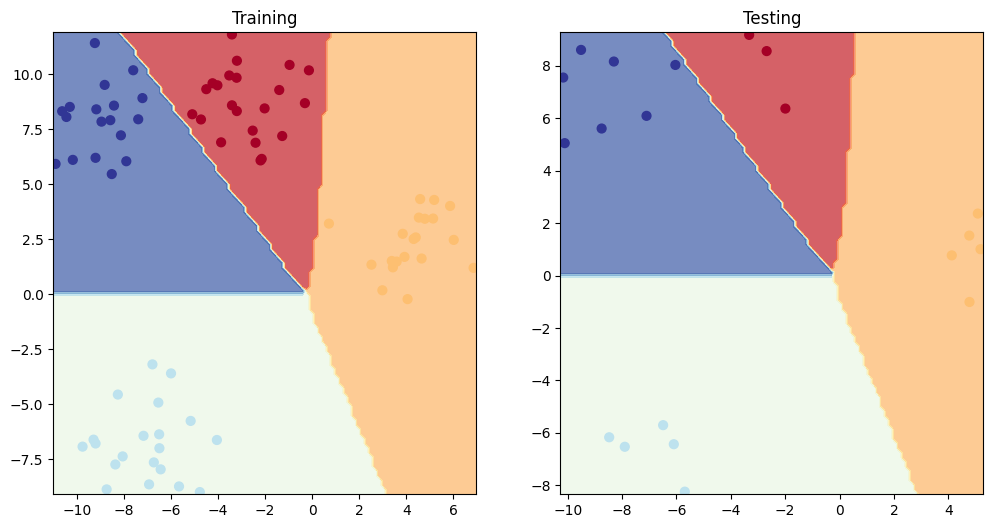

In [ ]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Training")
plot_decision_boundary(model=model_0, X=X_blob_train, y=y_blob_train)

plt.subplot(1,2,2)
plt.title("Testing")
plot_decision_boundary(model=model_0, X=X_blob_test, y=y_blob_test)

In [ ]:
# Make some predictions with our model
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_blob_test)
  y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

y_preds[:5], y_blob_test[:5]

(tensor([3, 2, 1, 2, 0]), tensor([3, 2, 1, 2, 0]))

In [ ]:
torch.eq(y_preds[:5], y_blob_test[:5])

tensor([True, True, True, True, True])

--------------------------
# A few more classification metrics... (to evaluate our classification model)

- Accuracy
- Precision
- Recall
- F1-Score
- Confusion matrix
- Classification report
- ...

https://lightning.ai/docs/torchmetrics/stable/

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.4/891.4 kB 16.7 MB/s eta 0:00:00


In [ ]:
from torchmetrics import Accuracy, Recall, Precision, F1Score, ConfusionMatrix
import matplotlib.pyplot as plt

# Accuracy
accuracy = Accuracy(task="multiclass", num_classes=4).to(device)
accuracy(y_preds, y_blob_test)

tensor(1.)

In [ ]:
# Recall
recall = Recall(task="multiclass", num_classes=4).to(device)
recall(y_preds, y_blob_test)

tensor(1.)

In [ ]:
# Precision
precision = Precision(task="multiclass", num_classes=4).to(device)
precision(y_preds, y_blob_test)

tensor(1.)

In [ ]:
# F1-Score measure
f1 = F1Score(task="multiclass", num_classes=4).to(device)
f1(y_preds, y_blob_test)

tensor(1.)

In [ ]:
# Confusion Matrix
cm = ConfusionMatrix(task="multiclass", num_classes=4).to(device)
cm(y_preds, y_blob_test)

tensor([[3, 0, 0, 0],
        [0, 5, 0, 0],
        [0, 0, 5, 0],
        [0, 0, 0, 7]])